# Definición del problema a resolver
• ¿Cuál es el problema?
- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?

- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?

- ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?

- Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas. 

• Acción que buscamos hacer para solucionar el problema

• ¿Cuáles son las variables disponibles?

• ¿En qué momento se va a implantar el modelo? ¿Qué variables hay disponibles en
el momento de llamada al modelo?

• ¿Cómo se va a validar el modelo?


Aquí hay que redactar una introducción explicando el caso y toda la parafernalia...

# Exploración general / inicial
• Dimensiones de la tabla y variables

• Analizar si las variables estarán disponibles en el momento de la llamada al modelo
(sino se estaría introduciendo información a futuro en el modelo)

• Exploración de la variable objetivo

• Rápido análisis de valores nulos

• Se explora el número de variables numéricas y categóricas y se decide qué proceso
realizar para tratarlas

• Transformaciones iniciales de algunas variables: formato de fechas, eliminar
espacios de una variable string, etc

• Analizar la variable objetivo: aislándola de las demás variables (quizás, a pesar de
no tener en cuenta las variables tenemos que sacar un 80% de accuracy.

In [186]:
#Librerías
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import plotly.express as px
import scipy.stats as ss

In [187]:
#Importamos los datos
df = pd.read_csv("../data/NCDB_1999_to_2014.csv")

C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning:

Columns (1,2,5,12) have mixed types.Specify dtype option on import or set low_memory=False.



In [188]:
print("El dataset está compuesto por", len(df.index), "filas y", len(df.columns), "columnas")
df.head(5)

El dataset está compuesto por 5860405 filas y 22 columnas


,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


In [189]:
# Cambio de nombre de las variables
new_names = ["year", "month", "weekday", "hour", "fatality", "vehicles_involved", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state", "vehicle_id", "vehicle_type", "vehicle_year", "passenger_id", "passenger_sex",
"passenger_age", "passenger_role", "passenger_fatality", "passenger_safety", "passenger_type"]

print(len(new_names) == len(df.columns))

df.columns = new_names

True


In [190]:
# Comprobamos el tipo de las variables, la mayoría son categóricas salvo fechas y variable objetivo(booleana)
# Algunas variables las podemos convertir en numéricas. ej. passenger_age
print(df.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index())
df.dtypes 

  feature_type  count
0        int64      2
1       object     20


year                   int64
month                 object
weekday               object
hour                  object
fatality               int64
vehicles_involved     object
crash_type            object
crash_place           object
crash_weather         object
surface_state         object
road_slope            object
traffic_state         object
vehicle_id            object
vehicle_type          object
vehicle_year          object
passenger_id          object
passenger_sex         object
passenger_age         object
passenger_role        object
passenger_fatality    object
passenger_safety      object
passenger_type        object
dtype: object

# Variables futuras y duplicados

El dataset contiene variables que no están disponible en el momento de la colisión y por tanto escapan al objetivo de nuestro ánalisis y otras que directamente no son de útilidad como IDs. También debemos prescindir de registros duplicados antes de eliminar los IDs

In [191]:
print(df.shape)
df = df.drop_duplicates().drop(["passenger_id","passenger_fatality", "vehicle_id"], axis=1)
df.shape

(5860405, 22)


(5855336, 19)

# Variable Objetivo

In [192]:
# Recodeado de la variable objetivo
# Antes: 1-fatality 2-no fatality
# Después: 1-fatality 0-no fatality
df['fatality'] = df['fatality'].replace({2:0})

In [193]:
#Ponemos la variable objetivo a la derecha del dataframe
new_columns = list(df.columns[0:4]) + list(df.columns[5:]) + list(df.columns[4:5])
df = df[new_columns]

In [194]:
# Plot variable 'fatality. Podemos ver que el dataset está muy desbalanceado
fatality_per = df['fatality'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
fatality_count = df['fatality'].value_counts().reset_index()
fataity_merge= pd.merge(fatality_per, fatality_count, on=['index'], how='inner')
fig = px.histogram(fataity_merge, x="index", y=['percent'], labels={'index':'fatality'})
fig.show()

# Valores Nulos

En el diccionario de datos encontramos varios tipos de datos ausentes.  En elPrincipalmente U, UU y UUUU que son datos estirctamente desconocidos.  
Luego tenemos los X, XX y XXXX que son no proporcionados por la jurisdicción, no encontramos ningun registro con esta etiqueta en los datos.  
Por otro lado tenemos los N, NN y NNNN que hacen referencia a que la variable no aplica al registro concreto. Por ejemplo en los registros creados para coches aparcados y peatones.  Más adelante decidiremos que hacer con estos registros.  
Por último los Q, QQ, QQQQ que son otras opciones que no aparecen en las posibles y tampoco deben ser tratados como nulos.

In [195]:
# Remplazamos U, UU y UUUU por NAs
df = df.replace({"U": np.nan, "UU": np.nan, "UUUU": np.nan})

In [196]:
# Análisis Nulos
nulos_col = pd.merge(df.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/df.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
18,passenger_safety,614507,object,0.104948
17,crash_place,504547,object,0.086169
16,road_slope,434626,object,0.074227
15,passenger_age,376225,object,0.064253
14,vehicle_year,323296,object,0.055214
13,passenger_sex,234351,object,0.040023
12,traffic_state,223451,object,0.038162
11,crash_type,178785,object,0.030534
10,passenger_type,175455,object,0.029965
9,crash_weather,87953,object,0.015021


In [197]:
null_rows = df.isnull().sum(axis=1).sort_values(ascending=False)
nulos_filas = pd.DataFrame(null_rows, columns=['nulos_filas'])  
nulos_filas['target'] = df['fatality'].copy()
nulos_filas['porcentaje_filas']= nulos_filas['nulos_filas']/df.shape[1]
nulos_filas

,nulos_filas,target,porcentaje_filas
5245711,16,1,0.842105
5245712,16,1,0.842105
769190,13,0,0.684211
2884064,13,0,0.684211
2177439,12,0,0.631579
...,...,...,...
2665912,0,0,0.000000
2665913,0,0,0.000000
2665914,0,0,0.000000
2665915,0,0,0.000000


In [198]:
# Podemos ver como la mayoría de filas con mas de 40% NAs no son fatalities
# En una proporción bastante menor a la que encontramos en el conjunto de datos
NA_0 = nulos_filas.target[(nulos_filas.porcentaje_filas>=0.40) & (nulos_filas.target==0)].count()
NA_1 = nulos_filas.target[(nulos_filas.porcentaje_filas>=0.40) & (nulos_filas.target==1)].count()
print(NA_0, NA_1)
NA_1/NA_0

5118 18


0.0035169988276670576

Tras hacer el analisis de los nulos por filas y por columnas. Procedemos a eliminar los registros con más nulos. En cuanto a columnas mantenemos todas puesto que solo una de ellas supera ligeramente el 10% de nulos una cantidad dentro de un treshold razonable y puede ser una variable de interés para el modelo. En cuanto a las filas vamos a eliminar todos los registros que contengan más de un 40% de nulos, es decir, 8 o más variables con valor nulo en un solo registro.

In [199]:
#Eliminando los registros con >40% nulos
nulos_40 = list(nulos_filas.index[nulos_filas.porcentaje_filas>=0.40])
df = df.loc[set(df.index)-set(nulos_40)].reset_index()

In [200]:
#TODO: ¿Que hacemos con dummies NN? 
print(df[(df['passenger_age']=='NN') & (df['fatality']==0)].shape)
df[(df['passenger_age']=='NN') & (df['fatality']==1)].shape

(17601, 20)


(319, 20)

# Transformación Básica de algunas variables

In [201]:
# Cambio de la variable vehicle_year a años de antigüedad y eliminamos vehicle_year
# Cambiamos passenger_age y vehicles_involved a númericas ninguna de las dos tiene NAs. 
# Sin embargo, passenger_age tiene valores NN para transformar la variable los haremos NA con 'coerce'
df['vehicle_year'] = pd.to_numeric(df.year - pd.to_numeric(df.vehicle_year, errors= "coerce"))
df = df.rename(columns={"vehicle_year": 'vehicle_age'})
df['passenger_age'] = pd.to_numeric(df['passenger_age'],"coerce")
df['vehicles_involved'] = pd.to_numeric(df['vehicles_involved'],"ignore")

In [202]:
def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
        -Descripción: Función que recibe un dataset y devuelve una lista con los nombres de las 
        variables categóricas
        -Inputs: 
            -- dataset: Pandas dataframe que contiene los datos
        -Return:
            -- lista_variables_categoricas: lista con los nombres de las variables categóricas del
            dataset de entrada con menos de 100 valores diferentes
            -- 1: la ejecución es incorrecta
    '''
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype == object):
                lista_variables_categoricas.append(i)
        else:
            other.append(i)

    return lista_variables_categoricas, other


In [203]:
dame_variables_categoricas(df)
lista_categoricas, lista_numericas = dame_variables_categoricas(df)

In [204]:
print(lista_categoricas, lista_numericas)

['month', 'weekday', 'hour', 'crash_type', 'crash_place', 'crash_weather', 'surface_state', 'road_slope', 'traffic_state', 'vehicle_type', 'passenger_sex', 'passenger_role', 'passenger_safety', 'passenger_type'] ['index', 'year', 'vehicles_involved', 'vehicle_age', 'passenger_age', 'fatality']


# En progreso (ignorar)

[1 2 3 4 5 6 7 8 9 10 11 12 '12' nan '01' '02' '11']
El porcentaje de fatalities/accidente para el mes 1 es del 1.508 %
El porcentaje de fatalities/accidente para el mes 2 es del 1.503 %
El porcentaje de fatalities/accidente para el mes 3 es del 1.562 %
El porcentaje de fatalities/accidente para el mes 4 es del 1.578 %
El porcentaje de fatalities/accidente para el mes 5 es del 1.643 %
El porcentaje de fatalities/accidente para el mes 6 es del 1.661 %
El porcentaje de fatalities/accidente para el mes 7 es del 1.913 %
El porcentaje de fatalities/accidente para el mes 8 es del 1.905 %
El porcentaje de fatalities/accidente para el mes 9 es del 1.772 %
El porcentaje de fatalities/accidente para el mes 10 es del 1.713 %
El porcentaje de fatalities/accidente para el mes 11 es del 1.662 %
El porcentaje de fatalities/accidente para el mes 12 es del 1.69 %
[1 2 3 4 5 6 7 '7' nan '1' '2' '3' '4' '5' '6']
[1 2 3 4 5 6 7 0]
El porcentaje de fatalities/accidente para el día de la semana 1 es del 1.5

0    97.938221
1     2.061779
Name: fatality, dtype: float64

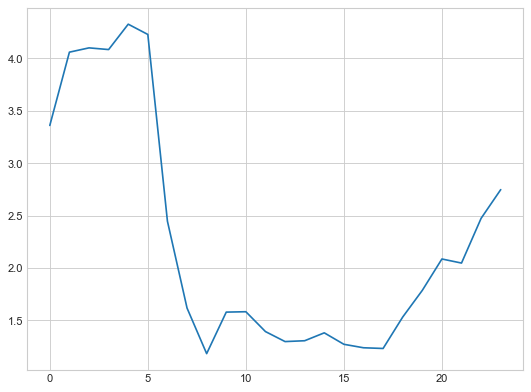

In [205]:
# Columna MONTH
print(df["month"].unique())
df["month"] = np.int8(df["month"].replace({"01": 1, "02": 2, "11": 11, "12" : 12}))
df = df[df["month"] != 0]
df["month"].unique()
month_analysis = df.groupby(["month", "fatality"]).size()

for i in range(1, 1+ np.int8(len(month_analysis)/2)):
    print("El porcentaje de fatalities/accidente para el mes",
    i ,"es del",round(month_analysis[i][1]/month_analysis[i].sum()*100, 3), "%")
month_analysis[2]
### Dividiremos la variable month en cuatro valores distintos, representando los distintos trimestres del año (Q1-4).
#### La razón para esto es la existencia de un patrón estacional en el que los distintos trimestres (o estaciones del año) tienen valores similares a la hora de relacionarse con la variable objetivo $fatality$
# df["month"] = df["month"].replace({1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4, 12:4})
## Columna Weekday
print(df["weekday"].unique())
df["weekday"] = np.int8(df["weekday"].replace({"7": 7, "1": 1, "2": 2, "3" : 3, "4":4, "5":5, "6":6}))
print(df["weekday"].unique())
#Las filas con NA en weekday (valor 0 para el día de la semana) son un número mínimo en comparación con el tamaño del data-set así que nos deshacemos de ellas
# Nos deshacemos de esas filas
df = df[df["weekday"] != 0]
weekday_analysis = df.groupby(["weekday", "fatality"]).size()

for i in range(1, 1+ np.int8(len(weekday_analysis)/2)):
    print("El porcentaje de fatalities/accidente para el día de la semana",
    i ,"es del",round(weekday_analysis[i][1]/weekday_analysis[i].sum()*100, 3), "%")
## Columna $hour$
### Opción 1: https://towardsdatascience.com/how-to-handle-cyclical-data-in-machine-learning-3e0336f7f97c
### Opción 2: Identificar distintos "tramos" de similar influencia en $fatalities$ y luego hotencodearlo. Habría que hacerlo por tramos para reducir, ya que 24 variables para la hora quizás sean demasiadas
df = df[df["hour"].notnull()]
df["hour"] = df["hour"].astype("int8")
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8,6), dpi=80)


hour_analysis = df.groupby(["hour", "fatality"]).size()
hour_values = list()

for i in range(0, int(len(hour_analysis)/2)):
    print("El porcentaje de fatalities/accidente para la hora",
    i ,"es del",round(hour_analysis[i][1]/hour_analysis[i].sum()*100, 3), "%")
    hour_values.append(hour_analysis[i][1]/hour_analysis[i].sum()*100)

hour_values = pd.DataFrame(hour_values)
hour_values.T.iloc[0].plot()

# He pensado en unificar las columnas de fecha pero he observado que la proporción de muertes / heridos es bastante diferente según el día de la semana (e imagino que también por la hora)

print(df.fatality.value_counts() / len(df.index) * 100)

df.loc[df["weekday"] == 6].fatality.value_counts() / len(df.loc[df["weekday"] == 6].index) * 100


# Gráficos

## Funciones

 Hemos generado varias funciones que nos ayudarán a aplicar un análisis descriptivo a las variables de nuestro dataset de manera eficiente e individual.
 En concreto, hemos optado por llevar a cabo un análisis de:

- La distribución de la variable objetivo en función de los valores de la variable que estamos analizando.
- La frecuencia absoluta de los accidentes mortales (variable objetiva = 1) en función de los valores de la variable analizada.
- El nivel de mortalidad en función de los valores de la variable que estamos analizando. Probabilidad = $\frac{Accidentes Mortales}{Accidentes Totales}$ x 100

In [206]:
# Funciones

### Función mortalidad (% / 100 Accidentes)

def mortalidad(columna, tipos, titulo):
    analysis = df.groupby([columna, "fatality"]).size()
    serie = list()
    for i in range(0, np.int8(len(analysis)/2)):
        serie.append(analysis[:,1].iloc[[i]].item() / (analysis[:,1].iloc[[i]].item() + (analysis[:,0].iloc[[i]].item())) * 100)
    analysis = pd.Series(serie, index = range(0, np.int8(len(analysis)/2)))
    plt.figure(figsize=(15,5))
    plot = analysis.plot(kind="bar", title = titulo)
    plot.set_xticklabels(tipos, rotation = 45)
    

### Función frecuencia absoluta

def frecuencia(columna, tipos, titulo):
    analysis = df.groupby(columna)["fatality"].count()
    plt.figure(figsize=(15,5))
    plot = analysis.plot(kind="bar", title=titulo)
    plot.set_xticklabels(tipos, rotation = 45)
    
    
### Función mortalidad total

def mortalidadtotal(columna, tipos, titulo):
    analysis = df.groupby(columna)["fatality"].sum() / df["fatality"].sum() * 100
    plt.figure(figsize=(15,5))
    plot = analysis.plot(kind="bar", title=titulo)
    plot.set_xticklabels(tipos, rotation = 45)


## 1. Colisiones y Tiempo

### 1.1. Observación del periodo completo

In [207]:
#Cambio df por df_ts para no añadir columnas al df sobre el que vamos a trabajar?
df_ts = pd.DataFrame()
df_ts["date"] = pd.DatetimeIndex(df["year"].map(str) + "-" + df["month"].map(str))
df_ts["fatal"] = np.where(df["fatality"]==1, 1, 0)
df_ts["non_fatal"] = np.where(df["fatality"]==0, 1, 0)

<ipython-input-208-2010bc5dfa7f>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Text(0, 0.5, 'Number of deadly colissions')

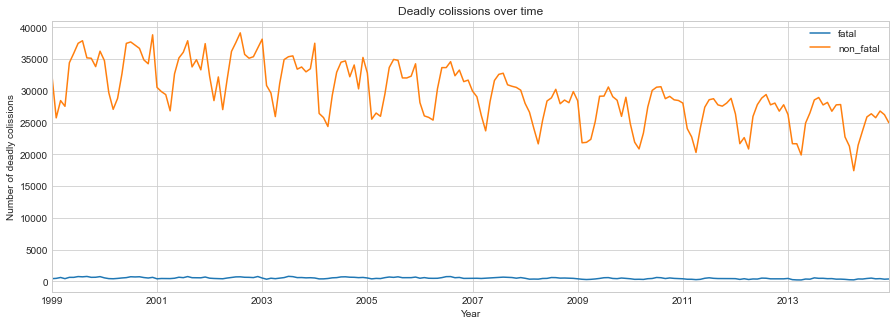

In [208]:
time_collision_both = df_ts.groupby('date')["fatal","non_fatal"].sum()
plot = time_collision_both.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

Text(0, 0.5, 'Number of deadly colissions')

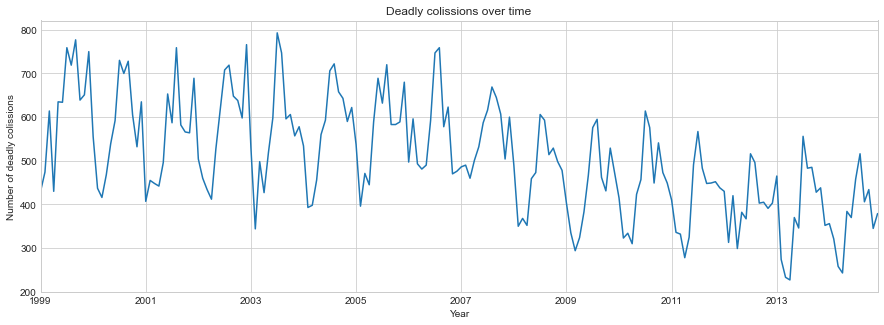

In [209]:
time_collision_fatal = df_ts.groupby('date')["fatal"].sum()
plot = time_collision_fatal.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

Text(0, 0.5, 'Number of deadly colissions')

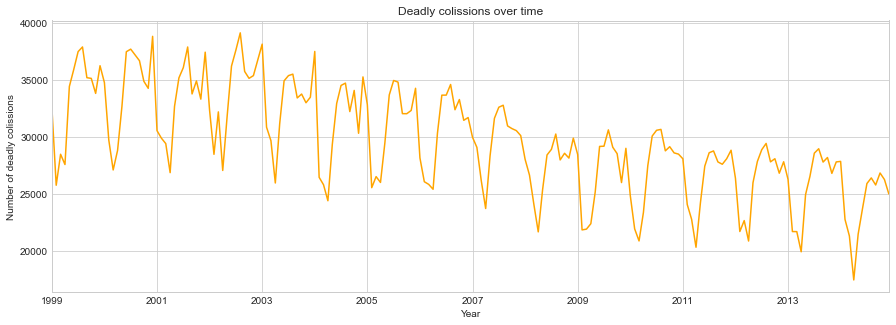

In [210]:
time_collision_nonfatal = df_ts.groupby('date')["non_fatal"].sum()
plot = time_collision_nonfatal.plot(figsize = (15,5), title = "Deadly colissions over time", color = "orange")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

### 1.2. Observación reducida a los últimos 5 años

Text(0, 0.5, 'Number of deadly colissions')

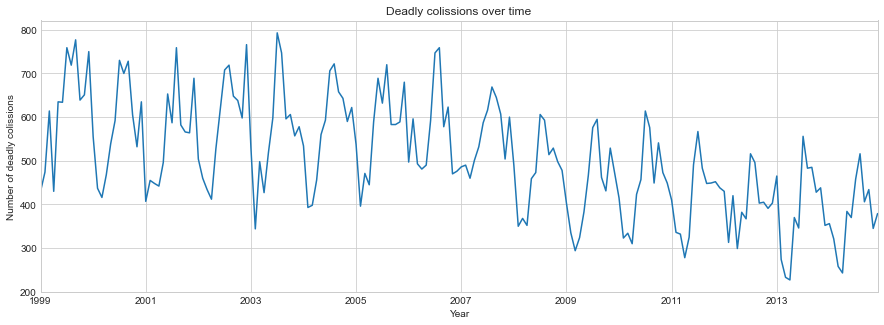

In [211]:
#TODO: Filtrar ultimos 5 años
#df_reduced = df.loc[df["date"] >= "2009"]

plot = time_collision_fatal.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

Text(0, 0.5, 'Number of deadly colissions')

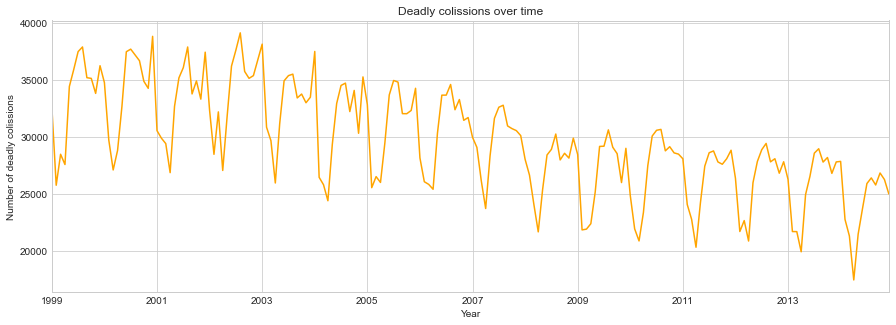

In [212]:
plot = time_collision_nonfatal.plot(figsize = (15,5), title = "Deadly colissions over time", color="orange")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

### 1.3 Correlación entre los valores de la variable objetivo

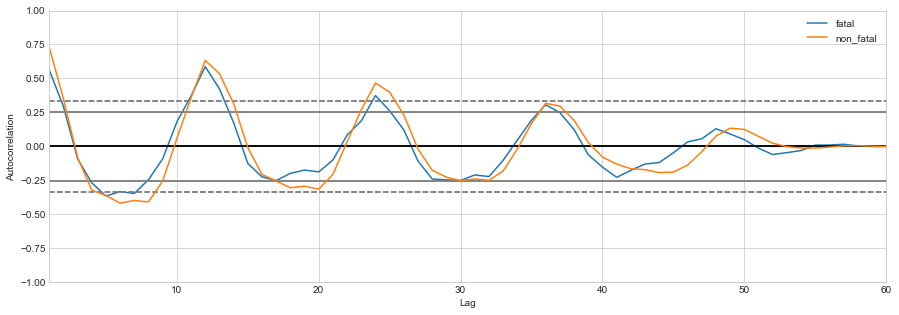

In [213]:
plt.figure(figsize=(15,5))
for c in time_collision_both.columns:
    autocorrelation_plot(time_collision_both[c][-60:],label=c);

C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



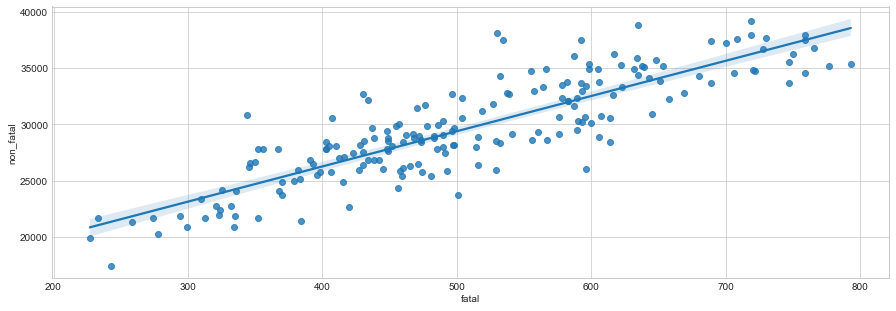

In [214]:
plt.figure(figsize=(15,5))
sns.regplot('fatal', 'non_fatal', data=time_collision_both);

In [215]:
corr = time_collision_both.corr()
print("La correlación entre los accidentes fatales y no fatales es de", str(round(corr["fatal"]["non_fatal"], 3)))
corr

La correlación entre los accidentes fatales y no fatales es de 0.861


,fatal,non_fatal
fatal,1.000000,0.861353
non_fatal,0.861353,1.000000


## 2. Análisis de los días de la semana y las horas

### 2.1. Días de la semana

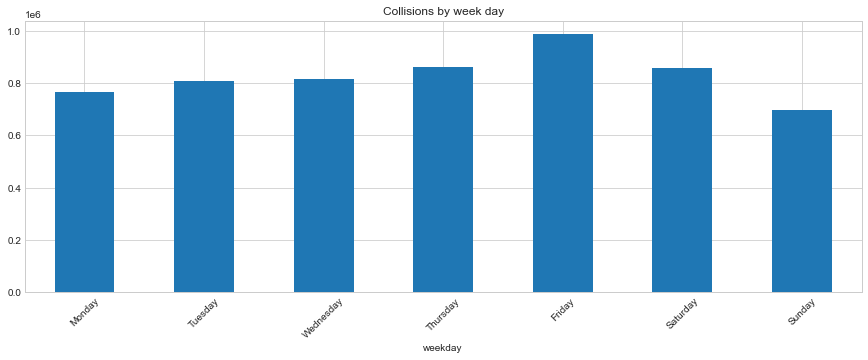

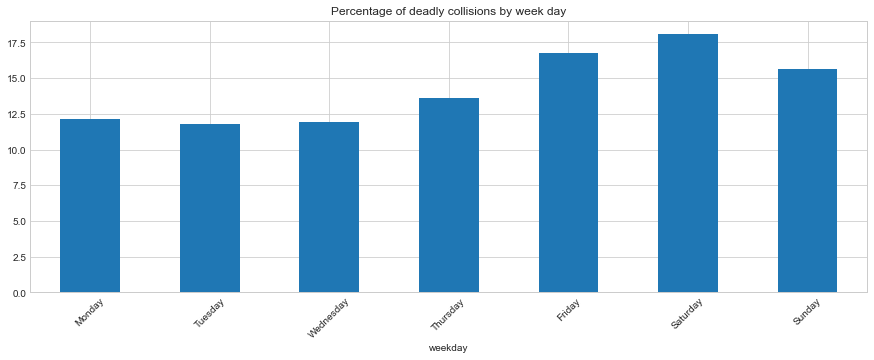

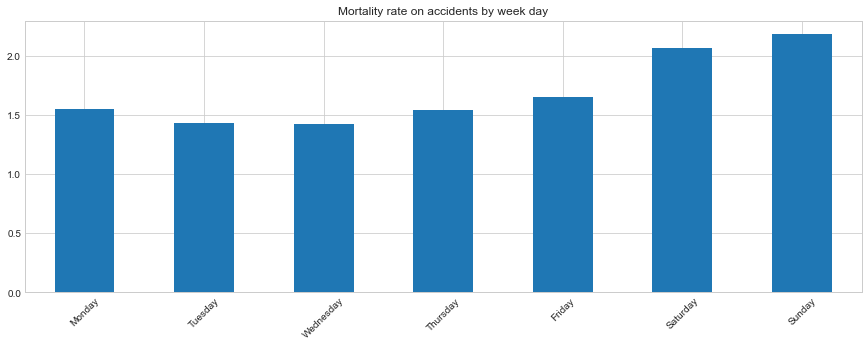

In [216]:
tipos = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
frecuencia("weekday", tipos, "Collisions by week day")
mortalidadtotal("weekday", tipos, "Percentage of deadly collisions by week day")
mortalidad("weekday", tipos, "Mortality rate on accidents by week day")

### 2.2. Horas del día

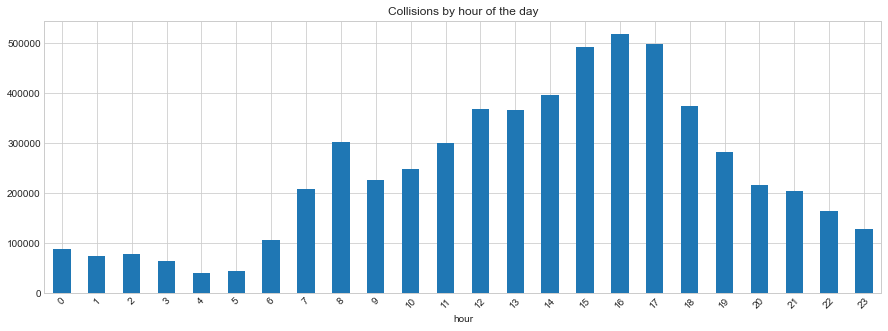

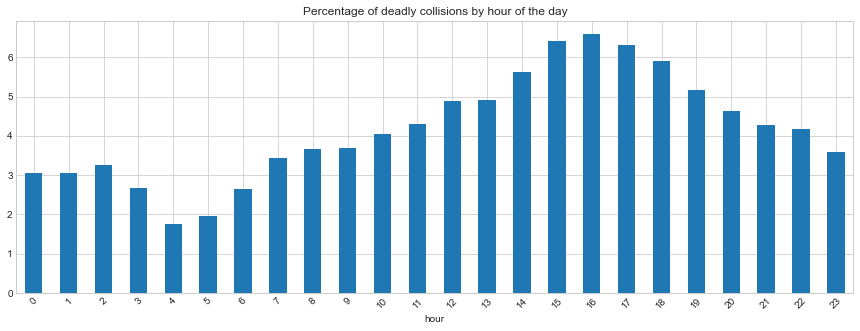

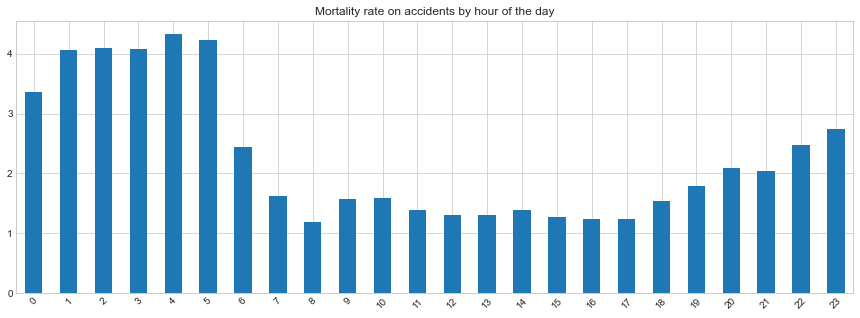

In [217]:
tipos = list(range(0, 24))
frecuencia("hour", tipos, "Collisions by hour of the day")
mortalidadtotal("hour", tipos, "Percentage of deadly collisions by hour of the day")
mortalidad("hour", tipos, "Mortality rate on accidents by hour of the day")

## 3. Colisiones y Carretera

### 3.1. Road Configuration

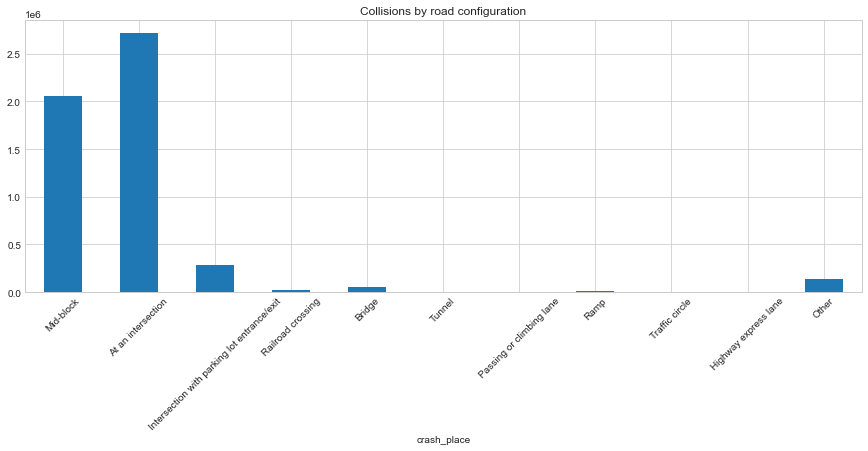

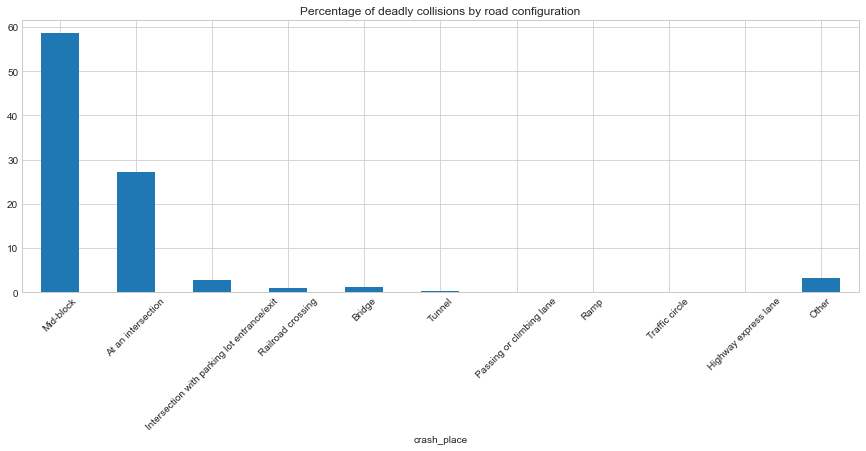

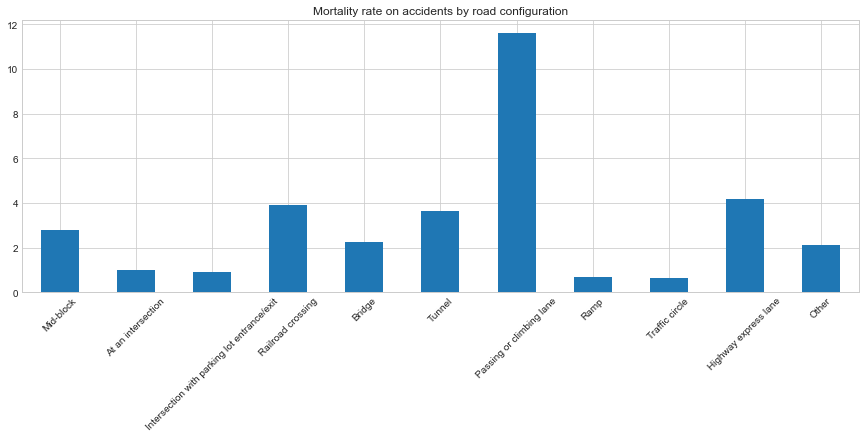

In [218]:
tipos = ['Mid-block','At an intersection','Intersection with parking lot entrance/exit',
            'Railroad crossing','Bridge','Tunnel','Passing or climbing lane',
             'Ramp','Traffic circle','Highway express lane', 'Other']

frecuencia("crash_place", tipos, "Collisions by road configuration")
mortalidadtotal("crash_place", tipos, "Percentage of deadly collisions by road configuration")
mortalidad("crash_place", tipos, "Mortality rate on accidents by road configuration")

### 3.2. Condiciones Climáticas

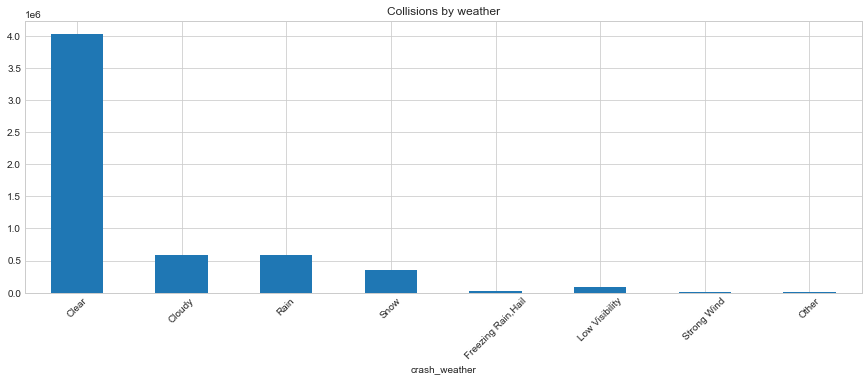

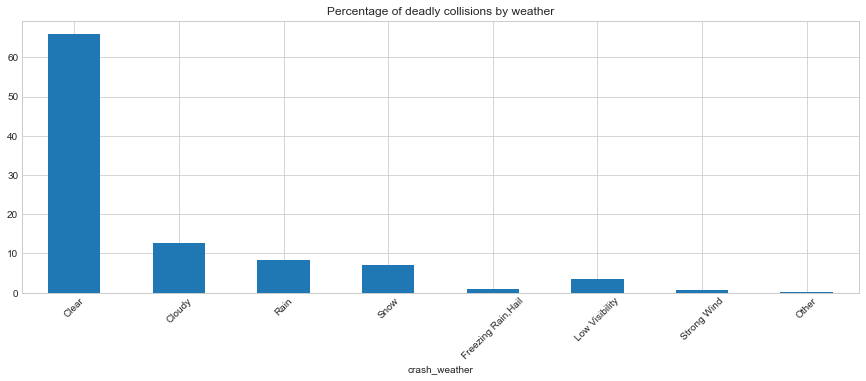

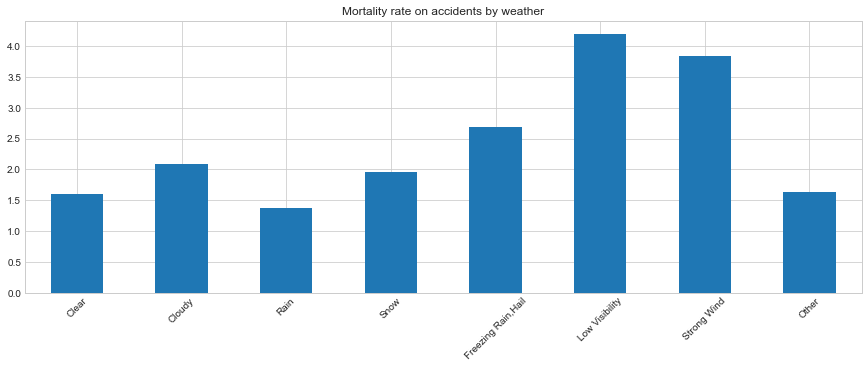

In [219]:
tipos = ['Clear','Cloudy','Rain','Snow','Freezing Rain,Hail',
                'Low Visibility','Strong Wind','Other']
frecuencia("crash_weather", tipos, "Collisions by weather")
mortalidadtotal("crash_weather", tipos, "Percentage of deadly collisions by weather")
mortalidad("crash_weather", tipos, "Mortality rate on accidents by weather")

### 3.3. Road surface

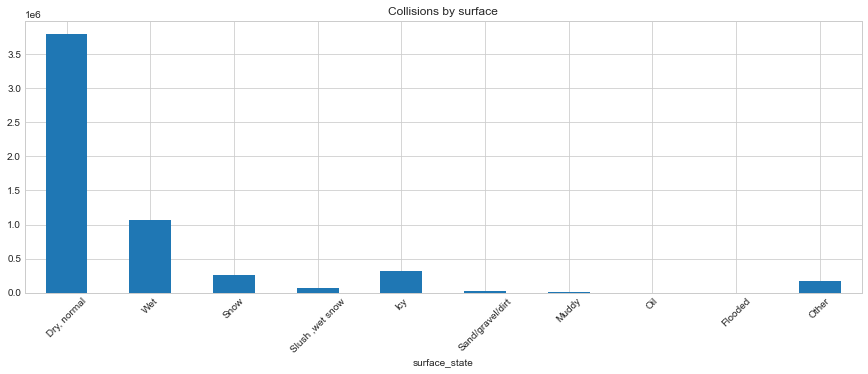

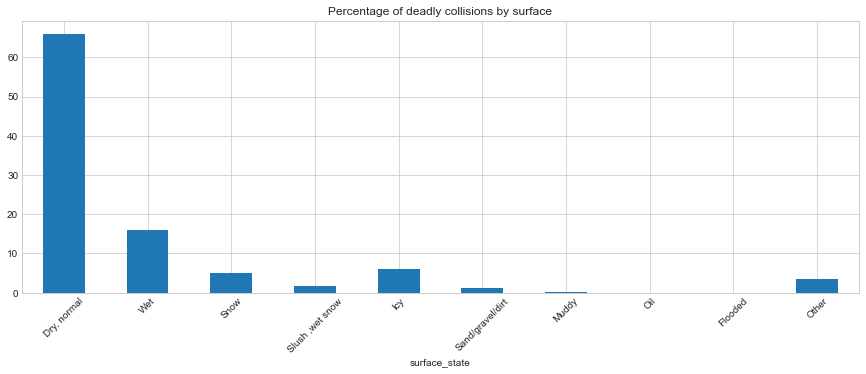

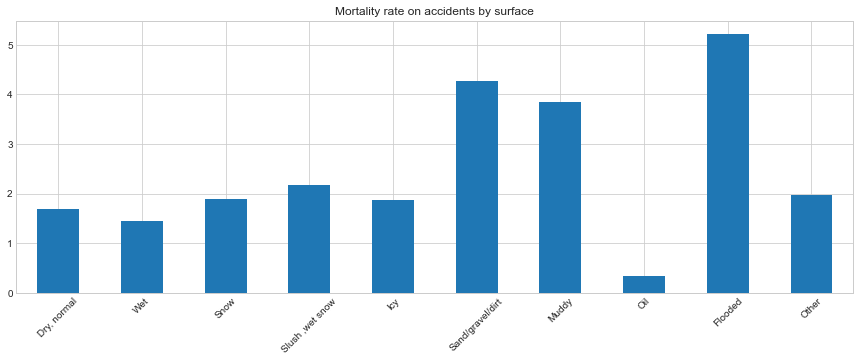

In [220]:
tipos = ['Dry, normal','Wet','Snow','Slush ,wet snow','Icy','Sand/gravel/dirt','Muddy','Oil','Flooded', 'Other']
frecuencia("surface_state", tipos, "Collisions by surface")
mortalidadtotal("surface_state", tipos, "Percentage of deadly collisions by surface")
mortalidad("surface_state", tipos, "Mortality rate on accidents by surface")

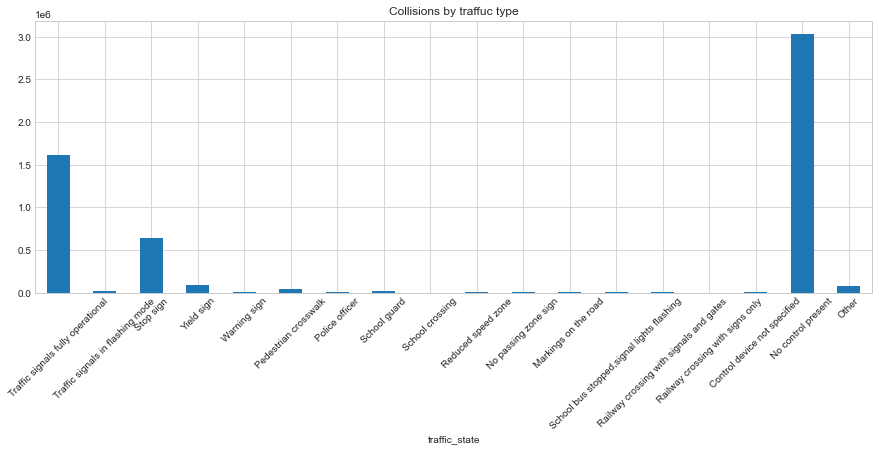

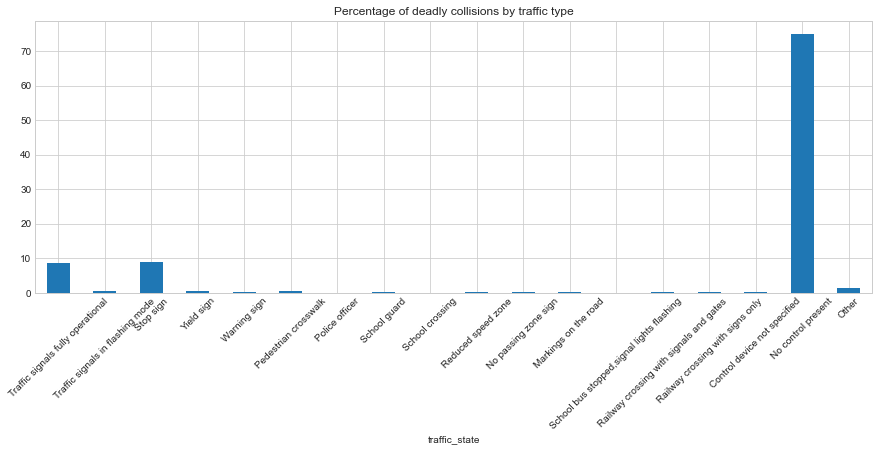

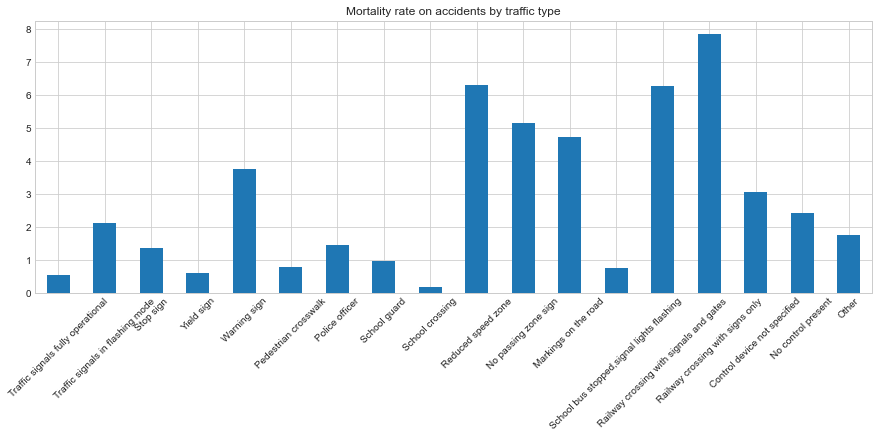

In [221]:
tipos = ['Traffic signals fully operational','Traffic signals in flashing mode',
             'Stop sign','Yield sign','Warning sign','Pedestrian crosswalk',
             'Police officer','School guard','School crossing','Reduced speed zone',
             'No passing zone sign','Markings on the road',
             'School bus stopped,signal lights flashing','Railway crossing with signals and gates',
             'Railway crossing with signs only','Control device not specified','No control present', 'Other']
             
frecuencia("traffic_state", tipos, "Collisions by traffuc type")
mortalidadtotal("traffic_state", tipos, "Percentage of deadly collisions by traffic type")
mortalidad("traffic_state", tipos, "Mortality rate on accidents by traffic type")

### 3.4. Road alignment (slope)

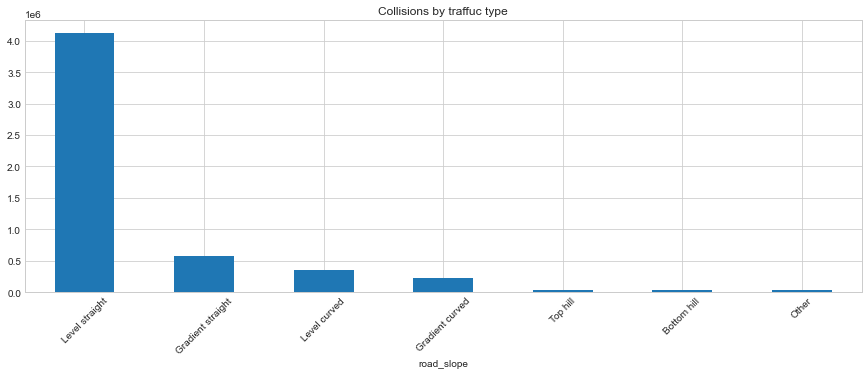

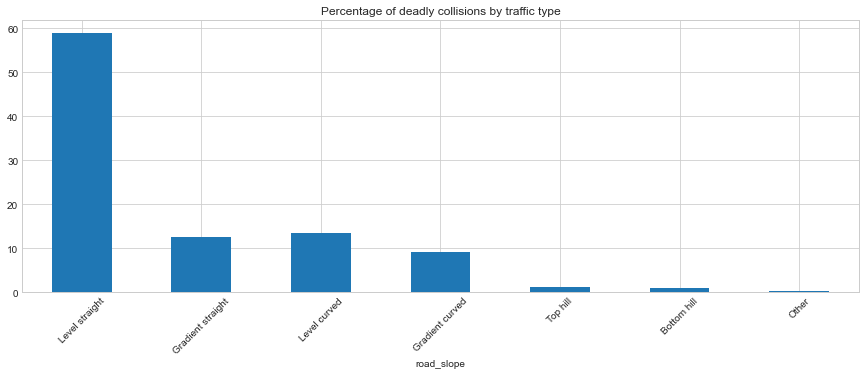

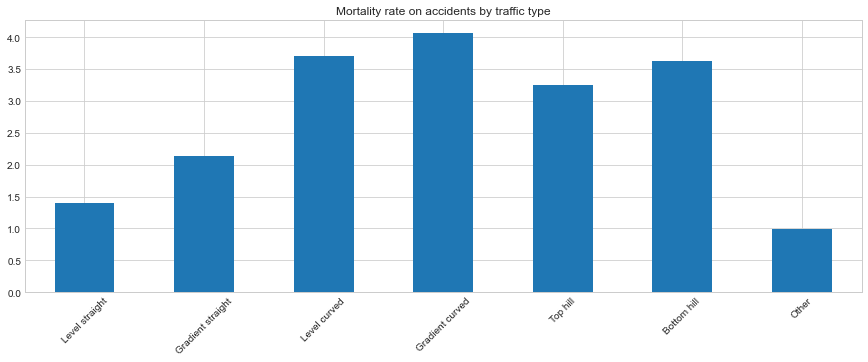

In [222]:
tipos = ['Level straight','Gradient straight',
        'Level curved','Gradient curved',
        'Top hill','Bottom hill',
        'Other']
             
frecuencia("road_slope", tipos, "Collisions by traffuc type")
mortalidadtotal("road_slope", tipos, "Percentage of deadly collisions by traffic type")
mortalidad("road_slope", tipos, "Mortality rate on accidents by traffic type")

## 4. Vehicles

### 4.1. Vehicle type

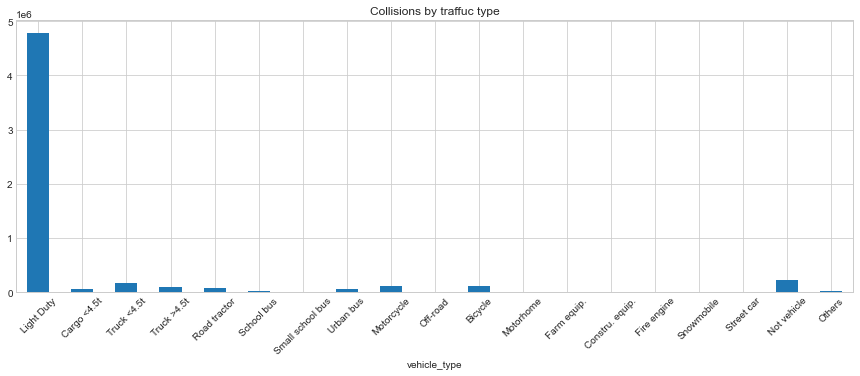

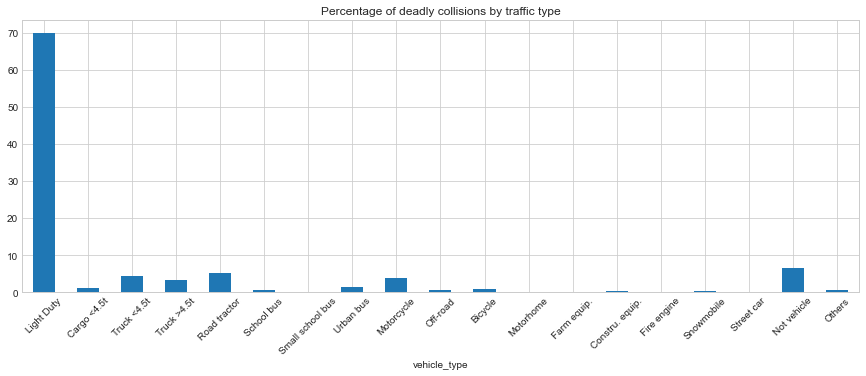

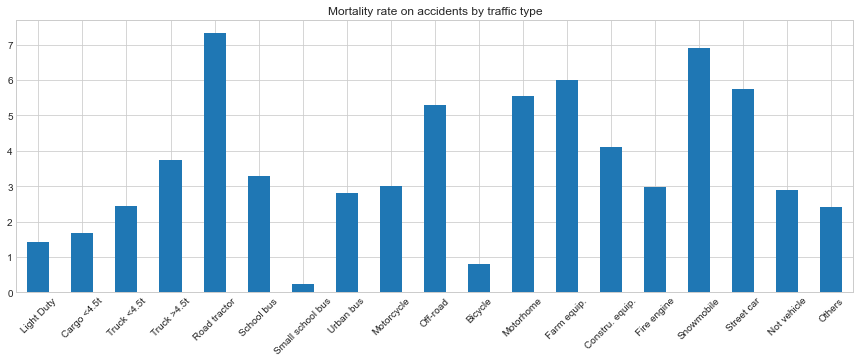

In [223]:
tipos = v_type = ['Light Duty', 'Cargo <4.5t', 'Truck <4.5t',
          'Truck >4.5t', 'Road tractor', 'School bus',
          'Small school bus', 'Urban bus', 'Motorcycle',
          'Off-road', 'Bicycle', 'Motorhome', 'Farm equip.',
          'Constru. equip.', 'Fire engine', 'Snowmobile',
          'Street car', 'Not vehicle', 'Others']
             
frecuencia("vehicle_type", tipos, "Collisions by traffuc type")
mortalidadtotal("vehicle_type", tipos, "Percentage of deadly collisions by traffic type")
mortalidad("vehicle_type", tipos, "Mortality rate on accidents by traffic type")

### 4.2. Vehicle Age

Text(0.5, 1.0, 'Mortality rate by vehicle age')

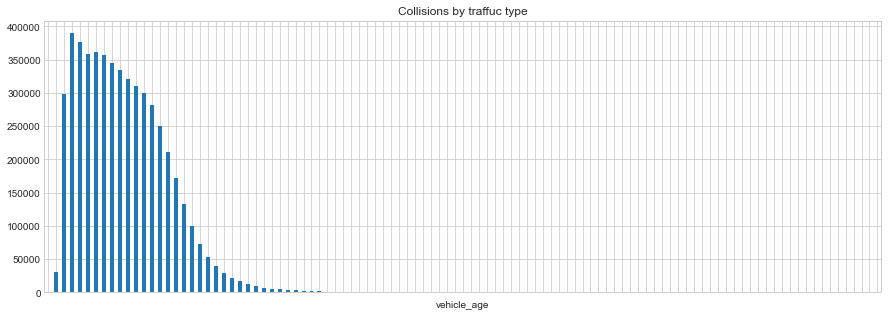

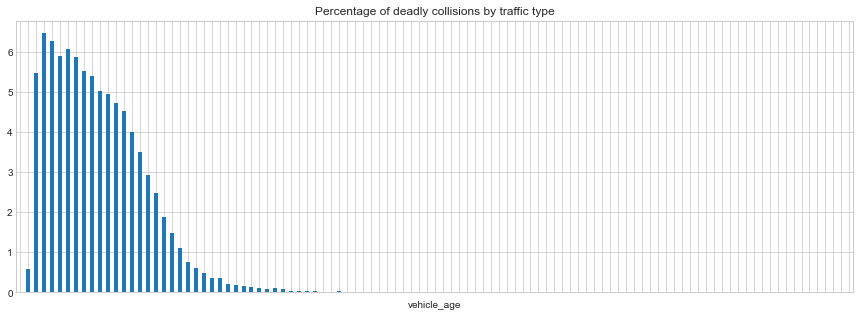

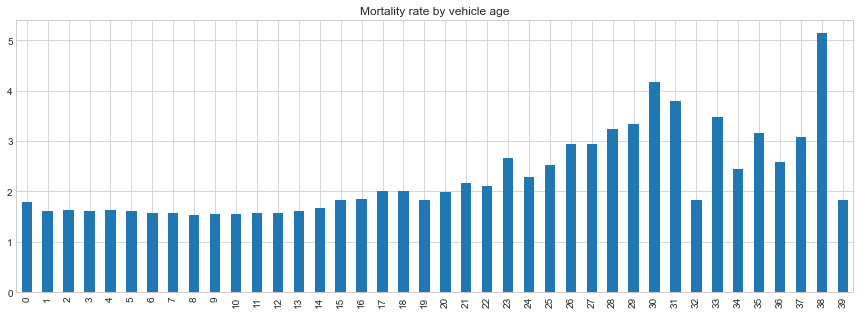

In [227]:
tipos = ()
frecuencia("vehicle_age", tipos, "Collisions by traffuc type")
mortalidadtotal("vehicle_age", tipos, "Percentage of deadly collisions by traffic type")


analysis = df.loc[(df['vehicle_age'] < 40) & (df['vehicle_age'] >= 0)].groupby(['vehicle_age', "fatality"]).size()
serie = list()
for i in range(0, np.int8(len(analysis)/2)):
    serie.append(analysis[:,1].iloc[[i]].item() / (analysis[:,1].iloc[[i]].item() + (analysis[:,0].iloc[[i]].item())) * 100)  
plt.figure(figsize=(15,5))
pd.Series(serie).plot(kind="bar")
plt.title("Mortality rate by vehicle age")

## Driver type

### 5.1. Driver Sex

In [228]:
# Replace M/F to 1/0
df.passenger_sex.replace({"M":1, "F":0}, inplace=True)

# Remove NA values (15k rows, 0.3% of total sample)
df.passenger_sex.replace('[^0-9]+',np.nan,regex=True,inplace=True)
df.passenger_sex.dropna(inplace=True)


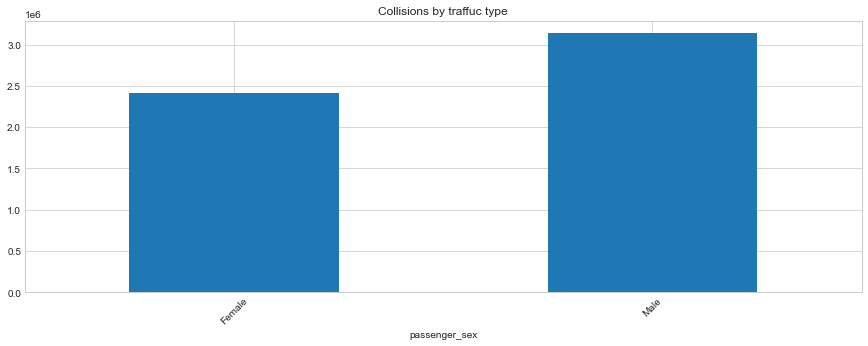

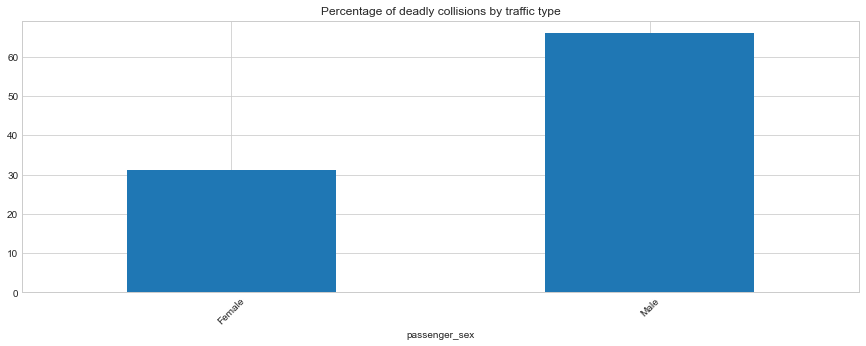

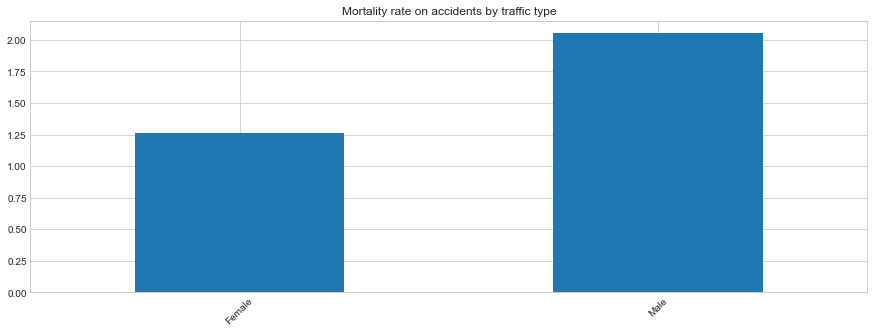

In [230]:
tipos = ["Female", "Male"]
frecuencia("passenger_sex", tipos, "Collisions by traffuc type")
mortalidadtotal("passenger_sex", tipos, "Percentage of deadly collisions by traffic type")
mortalidad("passenger_sex", tipos, "Mortality rate on accidents by traffic type")

### 5.2. Driver Age

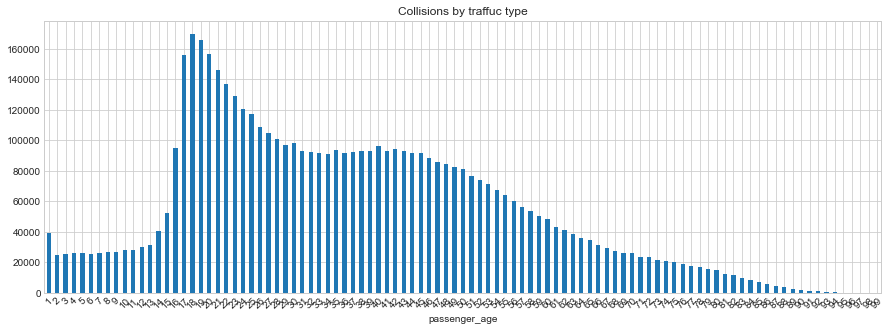

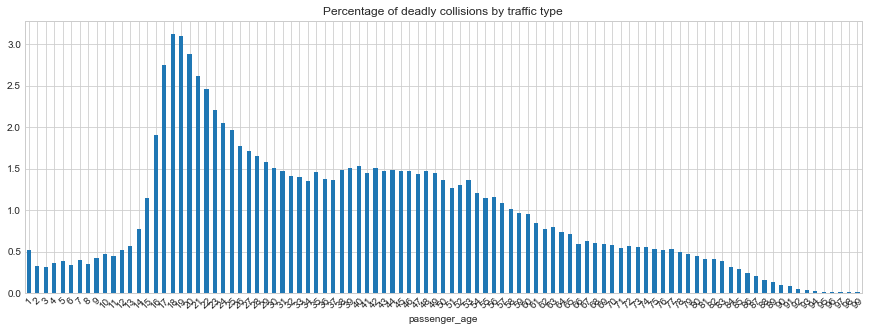

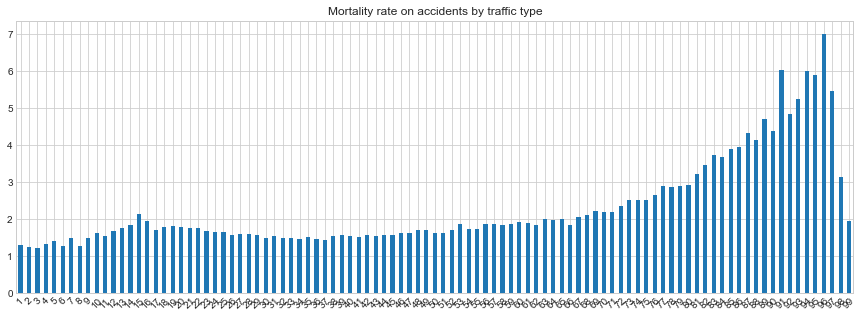

In [239]:
tipos = sorted(np.int8(df['passenger_age'].dropna().unique()))
frecuencia("passenger_age", tipos, "Collisions by traffuc type")
mortalidadtotal("passenger_age", tipos, "Percentage of deadly collisions by traffic type")
mortalidad("passenger_age", tipos, "Mortality rate on accidents by traffic type")

### 5.3. Driver safety

In [266]:
df = df.loc[df['passenger_safety'] != "11"]

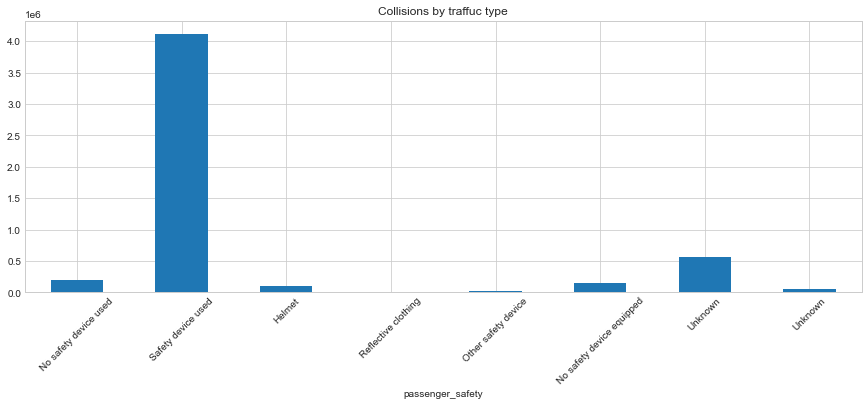

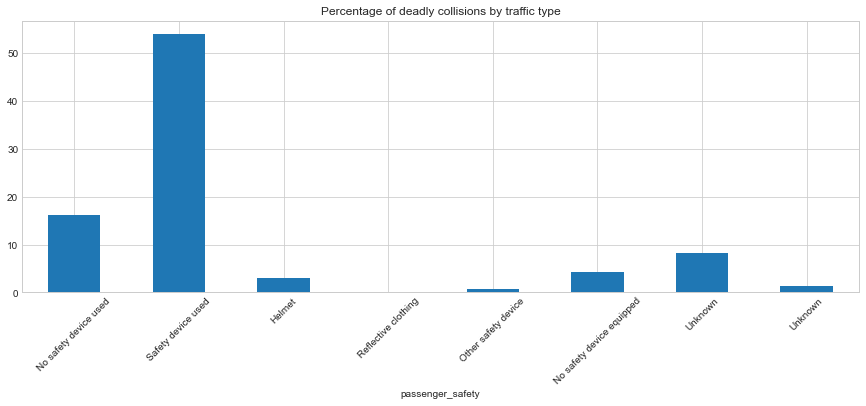

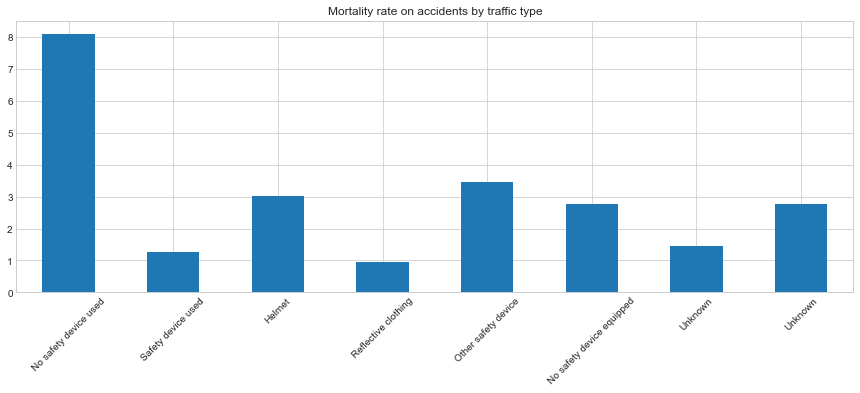

In [278]:
tipos = ['No safety device used','Safety device used','Helmet',
          'Reflective clothing',
          'Other safety device','No safety device equipped', 'Unknown', "Unknown"]


frecuencia("passenger_safety", tipos, "Collisions by traffuc type")
mortalidadtotal("passenger_safety", tipos, "Percentage of deadly collisions by traffic type")
mortalidad("passenger_safety", tipos, "Mortality rate on accidents by traffic type")

### 5.4. Road User Type

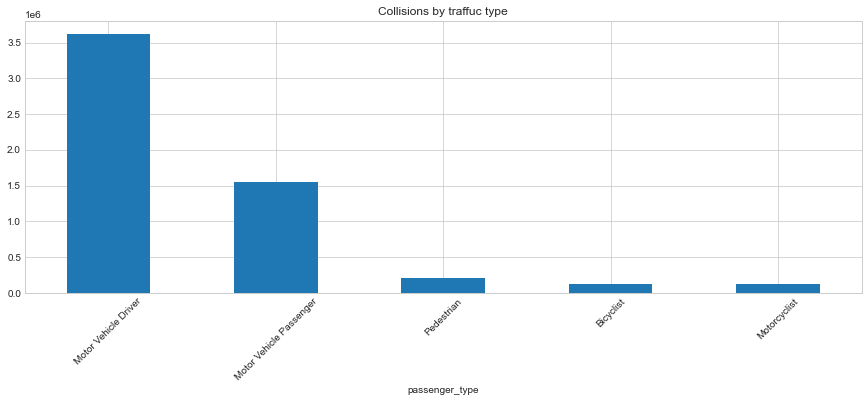

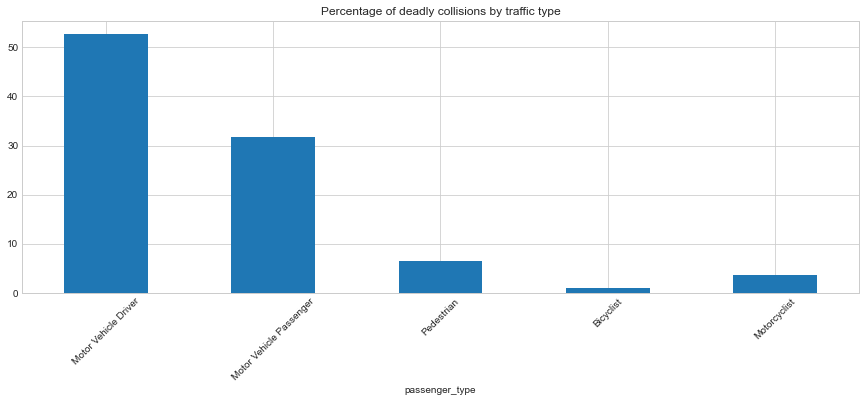

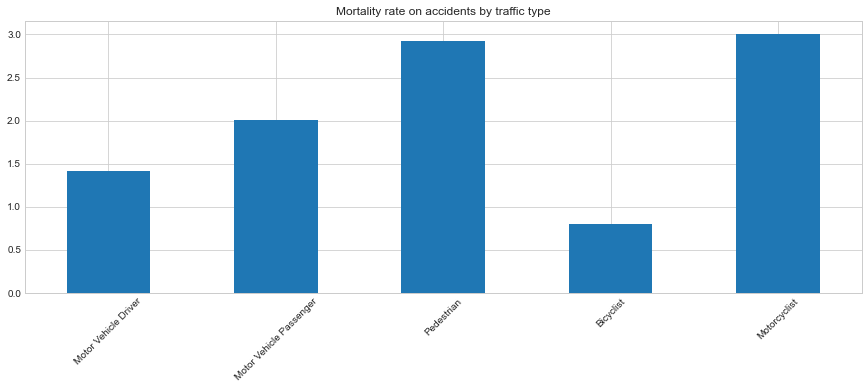

In [283]:
tipos = ["Motor Vehicle Driver", "Motor Vehicle Passenger", "Pedestrian", "Bicyclist", "Motorcyclist"]
frecuencia("passenger_type", tipos, "Collisions by traffuc type")
mortalidadtotal("passenger_type", tipos, "Percentage of deadly collisions by traffic type")
mortalidad("passenger_type", tipos, "Mortality rate on accidents by traffic type")

# Cramer Variables Categoricas

In [ ]:
def cramers_corrected_stat(x,y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

In [ ]:
def cramers_fatality(y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(df['fatality'].value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(df['fatality'], y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

In [ ]:
#TODO
#Quizá añadir despues de cada gráfico por variable
#Entre 0 y 1. Cuanto mayor, mayor relación entre variables
cramers_corrected_stat(df['fatality'], df['crash_place'])

In [ ]:
cramers_corrected_stat(df['fatality'], df['passenger_safety']) 

In [ ]:
cramers_corrected_stat(df['fatality'], df['crash_weather'])

In [ ]:
#FIXME
df[lista_categoricas].apply(cramers_fatality, axis = 1)

In [ ]:
#TODO
#Gráficos con llamada a función  
#Resolver tema NNs -- Fixed
#V de Cramer 
#Para modelo eliminar registros que no sean de conductor y tal vez peatón? Posible overfittng con muchas personas para un solo accidente

In [ ]:
df #sobran date, fatal y non_fatal.    
